# Slugtest Evaluation - Hvorslev and Bouwer Rice Solutions

*Notebook by Tanja Liesch, partly based on code by Gert Ghysels (https://github.com/VUB-HYDR/slugtest) and Karl DeBisschop (http://hydrotools.sourceforge.net/)*

## Hvorslev Solution

The Hvorslev solution is a simple, semi-empiric evalutaion method for slugtests. It uses a semi-log plot of $h_t/h_0$ over $t$ of the data. Linear regression is conducted on the values, that represent the aquifer response. The value at which the displacement has decreased to 37 $\% $ of its maximum value is used to compute K with the following formula:

$$
K = \frac{{r_c}^2 ln(L/r_{ew})}{2Lt_{37\% }}
$$


We try this out with the values of the excercise (Well #1 as an example):

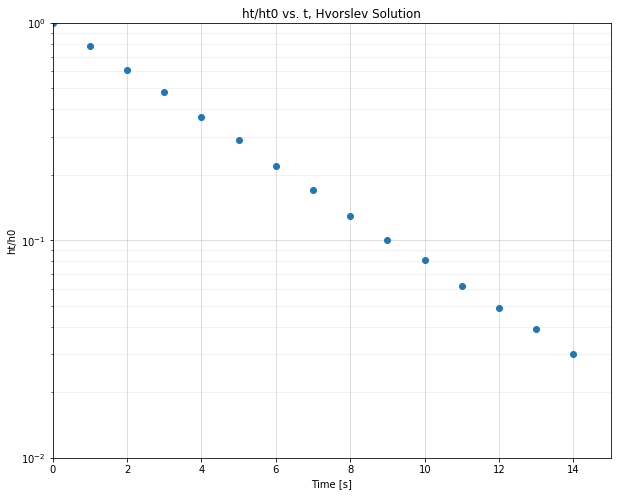

In [190]:
import numpy as np
import matplotlib.pyplot as plt

## Define Parameters and values

rc = 0.083 # effective radius well casing
L = 9 # length of well screen
rew = 0.25 # effective radius of well screen

## We leave all values in feet and convert the value of K from feet/s in m/s at the end, so only one conversion needed :-)

h0 = 1 # maximum displacement

## measured values of ht for t
t = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
ht = np.array([1, 0.78, 0.61, 0.48, 0.37, 0.29, 0.22, 0.17, 0.13, 0.10, 0.081, 0.062, 0.049, 0.039, 0.030])

## Normalize displacement
htnorm = ht/h0

## Plot values (semi-log plot)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
#set_size(10,8)
ax.set(xlabel='Time [s]', ylabel='ht/h0',  yscale='log',
       xlim=(0,15), ylim=(1e-2,1e0),
      title='ht/ht0 vs. t, Hvorslev Solution')

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)


ax.plot(t,htnorm, ls='', marker='o')

plt.show()



We now do a linear regression on the values:

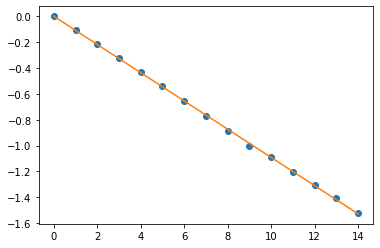

m = -0.10939222713301844, c = 0.0014348567112410964
rms residual = 4.20440595292021


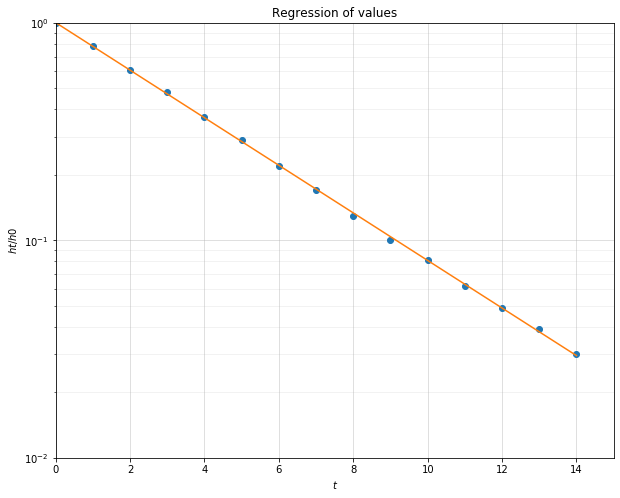

In [191]:
# fit t, lg(htnorm)

lgt = np.log10(htnorm)
coeffs = np.polyfit(t,np.log10(htnorm),  1)

# plot the data and the fitted straight line
plt.plot(t, lgt, ls='', marker='o')
fit_line = np.poly1d(coeffs)(t)
plt.plot(t, fit_line)
plt.show()

# Output the fitted coefficients and report the rms residual
print('m = {}, c = {}'.format(*coeffs))
rms_residual = np.sqrt(np.sum((fit_line - htnorm)**2))
print('rms residual =', rms_residual)

#Plot in nicer format (log y-axis)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.set(xlabel="$t$", ylabel='$ht/h0$', yscale='log',ylim=(1e-2,1e0), xlim=(0,15), title='Regression of values')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
ax.plot(t,htnorm, 'o')
fit_line = np.poly1d(coeffs)(t)
fit2 = 10**(fit_line)
ax.plot(t, fit2)
plt.show()


We now compute the time, where the displacement has reduced to 37 \% of its maximum value and use this value together with the other given parameters to compute K:

In [192]:
# y = mx + c --> x = (y-c)/m

m = coeffs[0]
c = coeffs[1]
t37 = (np.log10(0.37) - c)/m

print('t_37 = %.2f s' %(t37))

## compute K with semi-empirical Hvorslev equation
K = (rc**2)*(np.log(L/rew))/(2*L*t37)

print('K = %.2e feet/s' %(K))

## Finally we convert K from feet/s in m/s

Kms = K/3.28084
print('K = %.2e m/s' %(Kms))

t_37 = 3.96 s
K = 3.46e-04 feet/s
K = 1.06e-04 m/s


## Bouwer and Rice Solution

The Bouwer and Rice solution is a bit more complicated, but based also on a linear regression of values. The values for displacement are not normalized and plotted directly over t  in a semi-log plot.

K is then computed as


$$
K = \frac{{r_c}^2 ln(R_e/r_{ew})}{2L_e} \cdot \frac{1}{t} \cdot ln \frac{h_0}{h_t}
$$

The term

$$
\frac{1}{t} \cdot ln \frac{h_0}{h_t}
$$

is computed for one pair of values of the fitted regression line (choose any time for t an compute $h_t$).

The term $ln(R_e/r_{ew})$ is computed empirically with the following equations.

For fully penetrating wells:

$$
ln \frac{R_e}{r_{ew}} = \left[ \frac{1.1}{ln(L_w/r_{ew})} +  \frac{C}{L_e/r_{ew}} \right] ^{-1}
$$

and for partially penetrating wells:

$$
ln \frac{R_e}{r_{ew}} = \left[ \frac{1.1}{ln(L_w/r_{ew})} +  \frac{A+B \cdot ln \left[(M-L_w) \cdot r_{ew}\right] }{L_e/r_{ew}} \right] ^{-1}
$$

A, B and C are empirical parameters, dependent on $L_e$ and $r_{ew}$, that were determined by electrical resistance network simulation. The values can either be taken from the original paper of Bouwer and Rice or computed by approximate solutions. We use the analytic expressions for the values of these parameters, formulated by regression analysis, taken from DeBisschop (http://hydrotools.sourceforge.net/).

In [193]:
import numpy as np
import matplotlib.pyplot as plt

## Define Parameters and values (values from Well #1 of excercise)

rc = 0.083 # effective radius well casing
Le = 9 # length of well screen
rew = 0.25 # effective radius of well screen

x = np.log10(Le/rew)

if x < 2.554422663:
    A = 1.638445671 + 0.166908063 * x + 0.000740459 * np.exp(6.17105281 * x - 1.054747686 * x * x)
else:
    A = 11.00393028 - 170.7752217 * np.exp(-1.509639982 * x)


if x < 2.596774459: 
    B = 0.174811819 + 0.060059188 * x + 0.007965502 * np.exp(2.053376868 * x - 0.007790328 * x * x)
else:
    B = 4.133124586 - 93.06136936 * np.exp(-1.435370997 * x)


if x < 2.200426117: 
    C = 0.074711376 + 1.083958569 * x + 0.00557352 * np.exp(2.929493814 * x - 0.001028433 * x * x)
else:
    C = 15.66887372 - 178.4329289 * np.exp(-1.322779744 * x)

print('Le/rew = %.2f' %(x))
print('A = %.3f, B = %.3f, C = %.3f' %(A,B,C))

Le/rew = 1.56
A = 2.751, B = 0.459, C = 2.293


We start with the regression of the values.

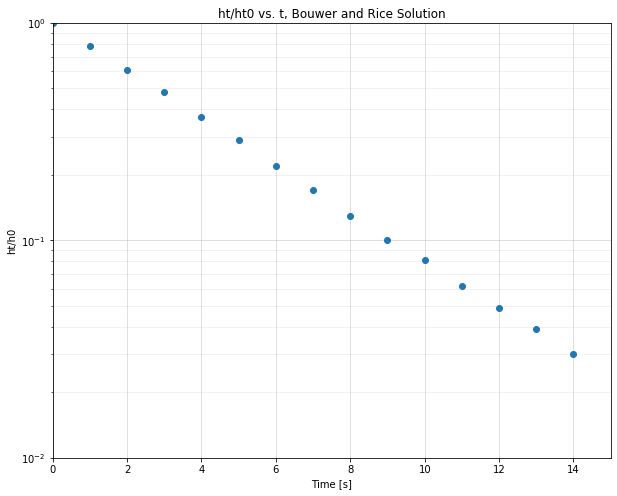

m = -0.10939222713301844, c = 0.0014348567112410964
rms residual = 4.20440595292021


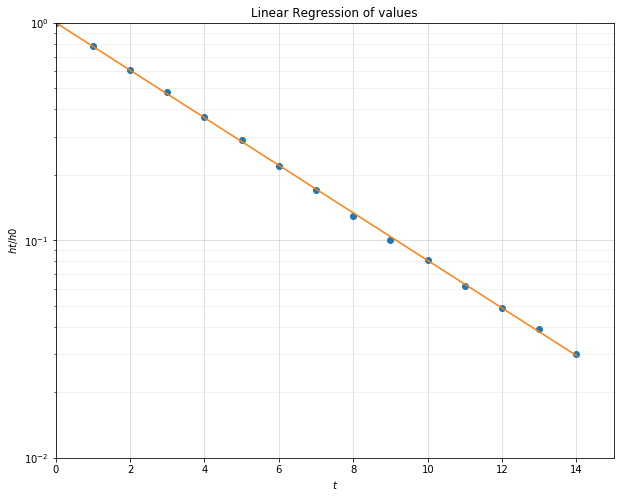

In [194]:
import numpy as np
import matplotlib.pyplot as plt

## Define Parameters and values

rc = 0.083 # effective radius well casing
L = 9 # length of well screen
rew = 0.25 # effective radius of well screen

## We leave all values in feet and convert the value of K in m/s at the end, so only one conversion needed :-)

h0 = 1 # maximum displacement

## measured values of ht for t
t = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
ht = np.array([1, 0.78, 0.61, 0.48, 0.37, 0.29, 0.22, 0.17, 0.13, 0.10, 0.081, 0.062, 0.049, 0.039, 0.030])


## Plot values (semi-log plot)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
#set_size(10,8)
ax.set(xlabel='Time [s]', ylabel='ht/h0',  yscale='log',
       xlim=(0,15), ylim=(1e-2,1e0),
      title='ht/ht0 vs. t, Bouwer and Rice Solution')

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.plot(t,ht, ls='', marker='o')

plt.show()

## fit t, lg(htn)

lgt = np.log10(ht)
coeffs = np.polyfit(t,np.log10(ht),  1)

## Output the fitted coefficients and report the rms residual
print('m = {}, c = {}'.format(*coeffs))
rms_residual = np.sqrt(np.sum((fit_line - ht)**2))
print('rms residual =', rms_residual)

## Plot in nice format (log y-axis)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.set(xlabel="$t$", ylabel='$ht/h0$', yscale='log',ylim=(1e-2,1e0), xlim=(0,15), title='Linear Regression of values')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
ax.plot(t,htnorm, 'o')
fit_line = np.poly1d(coeffs)(t)
fit2 = 10**(fit_line)
ax.plot(t, fit2)
plt.show()



We then compute one pair of values of t and h_t. As an example, we choose t as 10 seconds and compute $h_t$ with our regression coefficients;

In [195]:
# Regression line y = mx + c 

m = coeffs[0]
c = coeffs[1]

t = 10

ht = 10**((m * t + c) * h0)

print('t = 10 s, h_t = %.2f feet' %(ht))



t = 10 s, h_t = 0.08 feet


We now have all the values to compute the K value with the equations from above. We start with the quotient of $ln(R_e/r_{ew})$, for which we use $u$ as an abbreviation in the code. To distinguish between fully and partially penetrating wells, we use $uf$ and $up$.

In [196]:
## compute $ln(R_e/r_{ew})$

Le = 9  # value from the excercise, we have not used this yet
Lw = 18 # value from the excercise, we have not used this yet
M = 26  # value from the excercise, we have not used this yet

uf = ((1.1/(np.log(Lw/rew)))+(C/(Le/rew)))**(-1)

up = ((1.1/(np.log(Lw/rew)))+(((A+B*(np.log((M-Lw)*rew)))/(Le/rew))))**(-1)
      
print(uf)
print(up)



3.1162888230910095
2.919910858293464


We see a slight difference for fully and partially penetrating wells. We now go on with the final equation for K. Again we compute both cases, fully and partially penetrating wells. We can choose the resulting K for the case we need.

In [197]:
## Compute Kf for fully and Kp for partially penetrating wells

Kf = ((rc**2 * uf)/(2 * Le)) * (1/t) * np.log(h0/ht)

Kp = ((rc**2 * up)/(2 * Le)) * (1/t) * np.log(h0/ht)

# convert feet/s to m/s
Kfms = Kf/3.28084
Kpms = Kp/3.28084

print('In case of a fully penetrating well: K = %.2e m/s' %(Kfms))
print('In case of a partially penetrating well: K = %.2e m/s' %(Kpms))


In case of a fully penetrating well: K = 9.14e-05 m/s
In case of a partially penetrating well: K = 8.57e-05 m/s
